# Invariant Causal Prediction

by Jonas Peters, Niklas Pfister and Rune Christiansen, 18.06.2019

This notebook aims to give you a basic understanding of invariant causal prediction for causal inference. 


The method's goal is as follows: Suppose we are given data $(\mathbf{X}_1, Y_1), \ldots, (\mathbf{X}_n, Y_n)$ from a target variable $Y$ and a vector of $d$ predictors $\mathbf{X}$. We are then trying to determine the causal parents $\operatorname{pa}(Y) \subseteq \{1, \ldots, d\}$ of $Y$. The inference will be based on heterogeneity in the data (e.g., the data come from different interventional settings).

In [1]:
library(InvariantCausalPrediction)
library(seqICP)

Loading required package: glmnet
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

Loading required package: mboost
Loading required package: parallel
Loading required package: stabs
This is mboost 2.9-1. See ‘package?mboost’ and ‘news(package  = "mboost")’
for a complete list of changes.



## Environment based approach

We first start with a fundamental observation that we will exploit later.

Assume the $d+1$ dimensonal vectors $\mathbf{Z}_i=(Z^0_i,Z^1_i,\dots,Z^d_i)$ for $i = 1, \ldots, n$ are independent observations generated by (potentially) different interventional settings of the same linear structural causal model (SCM) such that the induced graphs are directed and acyclic (i.e., DAGs). Assume further that none of the interventions occurs directly on the variable $Z^0$. Then, for $Y:=Z^0$ and $\mathbf{X}:=(Z^1,\dots,Z^d)$ we have following invariance: There exists $\beta\in(\mathbb{R}\setminus\{0\})^{|\operatorname{pa}(Y)|}$ such that for all $i\in\{1,\dots,n\}$
it holds that
\begin{equation} \tag{1}
    Y_i=\mu+X_i^{\operatorname{pa}(Y)}\beta+\epsilon_i\text{ and }\epsilon_i \perp\!\!\!\perp X_i^{\operatorname{pa}(Y)},
\end{equation}
where $\epsilon_1,\dots,\epsilon_n$ are i.i.d. noise variables. 

### Exercise 1

Generate one sample from a distribution from the linear SCM
\begin{equation}
\mathcal{S}:\left\{
\begin{split}
X_i &= \epsilon_i^1\\
Y_i &= 1.5\cdot X_i + \epsilon_i^2\, ,
\end{split}\right.
\end{equation}
and a second sample from the same SCM under a shift intervention on $X$. Plot both samples in the same (X,Y)-scatterplot using different colors. Does the conditional distribution of $Y|X$ remain invariant, i.e., it is the same in both samples? What about the distribution of $Y$?

### Solution 1

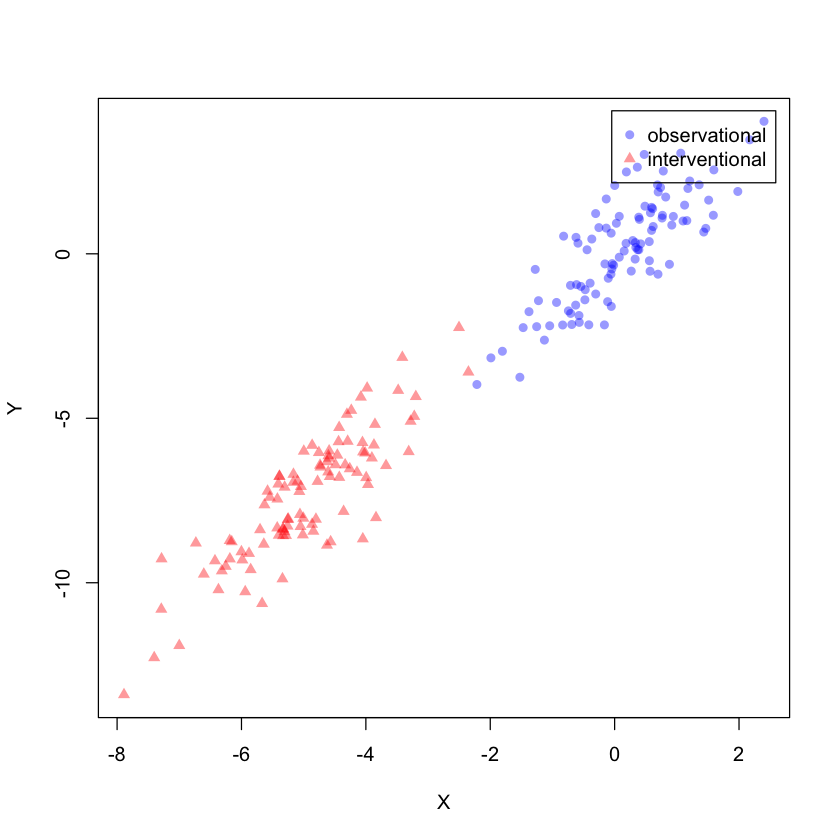

In [4]:
# Generate n=1000 observations from the observational distribution,
# and store observations in vectors called "Xa" and "Ya"
set.seed(1)
######################
# fill in
Xa <- rnorm(n = 100)
Ya <- 1.5 * Xa + rnorm(n = 100)
######################

# Generate n=1000 observations from the interventional distribution,
# and store observations in vectors called "Xb" and "Yb"
######################
# fill in
Xb <- rnorm(n = 100) - 5
Yb <- 1.5 * Xb + rnorm(n = 100)
######################

if(exists("Xa") & exists("Xb") & exists("Ya") & exists("Yb")){
    # Plot both samples
    red <- rgb(1,0,0,alpha=0.4)
    blue <- rgb(0,0,1,alpha=0.4)
    # Y vs X1
    plot(Xa,Ya,pch=16,col=blue,xlim=range(c(Xa,Xb)),ylim=range(c(Ya,Yb)),xlab="X",ylab="Y")
    points(Xb,Yb,pch=17,col=red)
    legend("topright",c("observational","interventional"),pch=c(16,17),col=c(blue,red),inset=0.02)
}

### End Solution 1

We now assume that we are given the data and try to infer $\operatorname{pa}(Y)$.
The method of invariant causal prediction exploits the invariance (1) from above. It goes over all sets of potential parents $\operatorname{pa}(Y)$ and finds all sets for which this invariance is satisfied.


To get a better understanding of how exactly invariant causal prediction performs this search, we consider the following toy data set.

In [5]:
load(file = "./InvariantCausalPredictionData1.RData")  # load data

We have now loaded a sample consisting of the variables $Y$, $X^1$, $X^2$ and $X^3$. The variables correspond to the columns of the matrix <tt>data</tt> and the rows correspond to independent observations from an underlying SCM. The first $140$ rows are sampled from an observational distribution, while the remaining $80$ rows come from an interventional setting for which it is known that none of the interventions occured directly on $Y$. In the following two exercises we will determine the parents of $Y$ using invariant causal prediction. First, we do this maually, and later we will make use of some functions already implemented in R.

### Exercise 2

Perform a regression of $Y$ on all possible sets of predictors (i.e. \{X1\}, \{X2\}, \{X3\}, \{X1, X2\}, \{X1, X3\}, \{X2, X3\}, \{X1, X2, X3\}). For each of the $7$ regressions plot the residuals vs the fitted values (this is called a Tukey-Anscombe plot). In each figure, plot the data points from the first environment in "blue" and the points from the second environment in "red". Determine whether the corresponding conditional remains invariant across the two environments. Moreover, check whether the distribution of $Y$ itself remains invariant. What is the parent set? Hint: Think about which sets are definetly *not* the correct parent sets.

### Solution 2

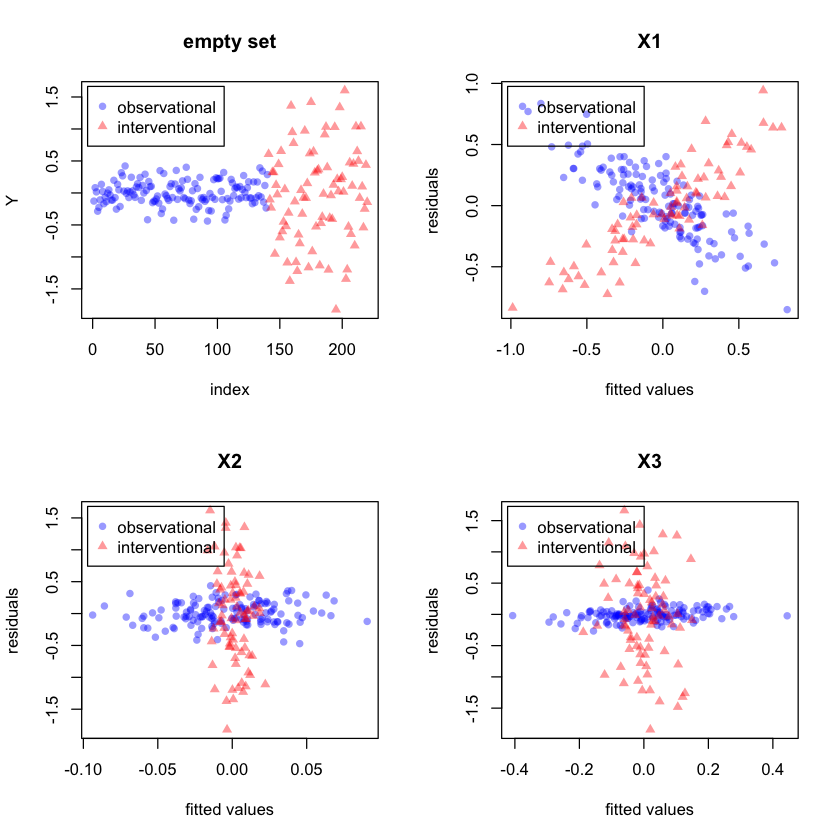

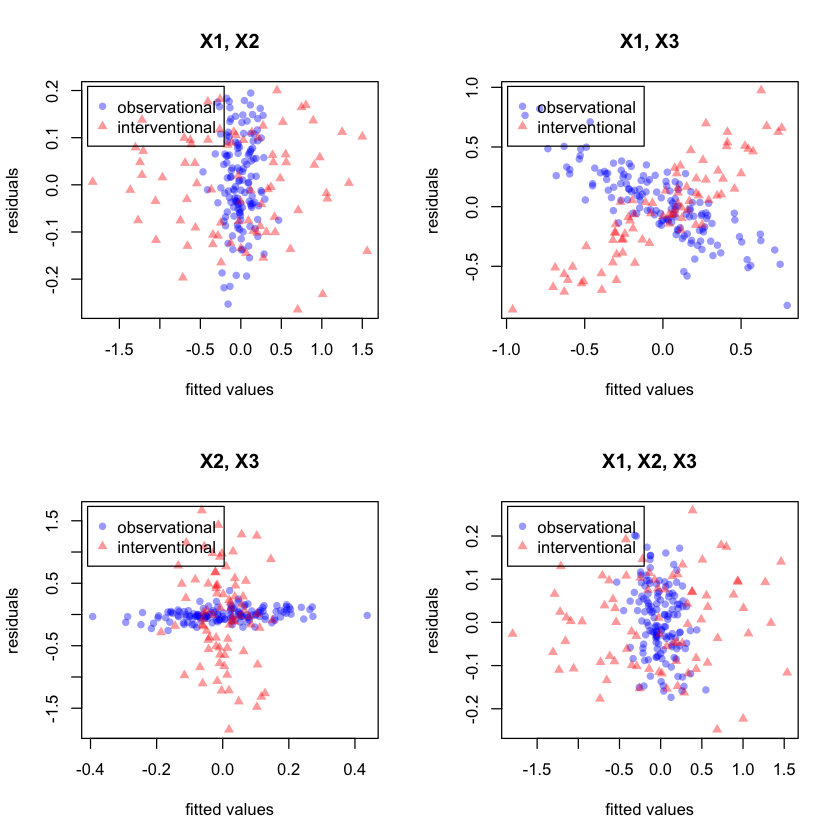

In [34]:
# extract response and predictors
Y <- data[,1]
Xmat  <- data[,2:4]

# define the potential parent sets
S <- list( c(1), c(2), c(3), c(1,2), c(1,3), c(2,3), c(1,2,3))

# perform regression for each set in S
resid <- fitted <- vector("list", length(S))
for(i in 1:length(S)){
  # regress Y linearly on the i'th set S (e.g. using lm.fit)
  # store the residuals in resid[[i]]
  # and the fitted values in fitted[[i]]
  #########################
  ## fill in
    a <- lm.fit(y = Y,x = data.matrix(Xmat[,S[[i]] ]) )
    resid[[i]] <- a$residuals
    fitted[[i]] <- a$fitted.values
  #########################
}

filledInResid <- all(unlist(lapply(resid, length)) == length(Y))
filledInFitted <- all(unlist(lapply(fitted, length)) == length(Y))

if(filledInResid & filledInFitted){
    # plot the resulting
    env <- c(rep(0,140),rep(1,80))
    par(mfrow=c(2,2))
    red <- rgb(1,0,0,alpha=0.4)
    blue <- rgb(0,0,1,alpha=0.4)
    names <- c("X1", "X2", "X3", "X1, X2", "X1, X3", "X2, X3", "X1, X2, X3")
    # plot Y vs index (empty set)
    plot((1:length(Y))[env==0], Y[env==0], pch=16, col=blue, xlim=c(0,220), ylim=range(Y), xlab="index", ylab="Y", main="empty set")
    points((1:length(Y))[env==1], Y[env==1], pch=17, col=red)
    legend("topleft",c("observational","interventional"),pch=c(16,17),col=c(blue,red),inset=0.02)
    # all remaining potential sets
    for(i in 1:length(S)){
        plot(fitted[[i]][env==0], resid[[i]][env==0], pch=16, col=blue, xlim=range(fitted[[i]]), ylim=range(resid[[i]]), xlab="fitted values", ylab="residuals", main=names[i])
        points(fitted[[i]][env==1], resid[[i]][env==1], pch=17, col=red)
        legend("topleft",c("observational","interventional"),pch=c(16,17),col=c(blue,red),inset=0.02)
    }
}

### End of Solution 2

### Exercise 3

For the same data set apply the invariant causal prediction function <tt>ICP</tt> form the package <tt>InvariantCausalPrediction</tt> to determine the parent set. Hint: You will need to define a vector <tt>ExpInd</tt> which has the same length as the number of observations and indicates from which environment each observations comes (e.g. $0$ for observational data and $1$ for interventional data).

### Solution 3

In [36]:
library(InvariantCausalPrediction)

# 140 Rows are sampled from the obs. distribution
# 80 Rows are sampled from the interventional distrib.
ExpInd <- c(rep(1, 140), rep(2, 80))
n <- length(ExpInd)

ICP(X = Xmat, Y = Y, ExpInd = ExpInd)


 *** 25% complete: tested 2 of 8 sets of variables 
 accepted set of variables 1,2
 accepted set of variables 1,2,3


 Invariant Linear Causal Regression at level 0.01 (including multiplicity correction for the number of variables)
 Variables: X1, X2 show a significant causal effect
 
     LOWER BOUND  UPPER BOUND  MAXIMIN EFFECT  P-VALUE    
X1        -0.73        -0.67           -0.67   <1e-09 ***
X2         0.57         0.65            0.57   0.0048 ** 
X3        -0.33         0.00            0.00   0.5976    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



### End of Solution 3

## Extension to an environment-free approach

In the above exercises we knew which observations corresponded to the observational and which to the interventional setting. In this section we want to show that we can still apply a similar methodology even if this environment information is not known. All we need is a sequential ordering of the data. For example, the data could be grouped together for each environment or the interventions could change continuously across time. We illustrate this using the following toy example.

In [37]:
load(file = "./InvariantCausalPredictionData2.RData")  # load data2

The matrix <tt>data2</tt> contains the three variables $Y$, $X^1$ and $X^2$ as columns and each row corresponds to an independent observations from the same SCM under smoothly changing interventions. To be more precise, the interventions correspond to smooth shifts in the variance of the noise.

### Exercise 4

Use the invariant causal prediction function for sequential data <tt>seqICP</tt> from the package <tt>seqICP</tt> to find an estimate of the parent set for the variable $Y$. Set the parameter <tt>test</tt> to "smooth.variance", this leads the <tt>seqICP</tt> to performs a hypothesis test tuned against alternatives that result from smooth variance interventions.

### Solution 4

In [41]:
library(seqICP)

seqICP(X = data.matrix(data2[, c("X1", "X2")]), Y = data.matrix(data2[, "Y"]), test = "smooth.variance")

$parent.set
[1] 1

$test.results
  ind    p.value   test.stat  crit.value  p
1   1 0.00990099 0.004773741 0.004199092 NA
2   2 0.09900990 0.004164631 0.004212910 NA
3   3 0.00990099 0.004492339 0.004208505 NA
4   4 0.02970297 0.004476828 0.004225677 NA

$S
$S[[1]]
numeric(0)

$S[[2]]
[1] 1

$S[[3]]
[1] 2

$S[[4]]
[1] 1 2


$p.values
[1] 0.00990099 1.00000000

$coefficients
     coefficients lower bound upper bound
[1,]    0.0114781  -0.1121664   0.1406507
[2,]    1.0303043   0.9514150   1.1091936
[3,]    0.0000000   0.0000000   0.0000000

$stopIfEmpty
[1] TRUE

$modelReject
[1] FALSE

$pknown
[1] FALSE

$alpha
[1] 0.05

$n.var
[1] 2

$model
[1] "iid"

attr(,"class")
[1] "seqICP"

### End of Solution 4

## References

[1] Peters, J., P. Bühlmann, and N. Meinshausen (2016). *Causal inference using invariant prediction:
identification  and  confidence  intervals*. Journal of the Royal Statistical Society, Series B (with discussion)
78 (5), 947–1012.

[2] Pfister, N., P. Bühlmann and J. Peters (2018). *Invariant Causal Prediction for Sequential Data*. Journal of the American Statistical Association (accepted), ArXiv e-prints (1706.08058).